In [1]:
!pip install tqdm
!pip install torch-xla
from IPython.display import clear_output
clear_output()

In [2]:
!git clone https://github.com/TranDung6129/Eikonal-Equation-Solver
!pip install git+https://github.com/Ulvetanna/EikoNet.git 
!pip install eikonalfm==0.9.5 
!pip install git+https://github.com/sgrubas/NES.git 
clear_output()

In [5]:
import numpy as np
import tensorflow as tf
import torch
from tqdm.keras import TqdmCallback
from eikonalfm import factored_fast_marching as ffm
from eikonalfm import distance
import NES
from EikoNet import model as EikoNet
import holoviews as hv
import misc
import velocity 
hv.extension('matplotlib')

clear_output()

# Loading velocity model

In [6]:
# EikoNet by default is applied for 3D models, create pseudo 3D model of Marmousi
Vel2D = misc.Marmousi(smooth=3, section=[[600, 881], None])
vmin, vmax = Vel2D.min, Vel2D.max
xmin, zmin = Vel2D.xmin
xmax, zmax = Vel2D.xmax
nz, nx = 281, 281

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
Xr_2d = np.stack(np.meshgrid(x, z, indexing='ij'), axis=-1)
V_2d = Vel2D(Xr_2d)

# Converting to pseudo 3D
y = np.array([0.0, 1e-3])
V_3d = np.tile(V_2d[..., None], reps=(1, 1, len(y)))

Xr_3d = np.stack(np.meshgrid(x, z, y, indexing='ij'), axis=-1)
Vel3D = velocity.Interpolator(V_3d, x, z, y)


In [7]:
# Adaption for EikoNet format

class EikoNetVelocity:
    def __init__(self, Vel):
        self.xmin = Vel.xmin
        self.xmax = Vel.xmax
        self.projection = None
        self.f = Vel
    
    def eval(self, Xp):
        Yp = np.zeros((Xp.shape[0], 2))
        Yp[:, 0] = self.f(Xp[:, :3])
        Yp[:, 1] = self.f(Xp[:, 3:])
        return Yp

EikoNet_Vel3D = EikoNetVelocity(Vel3D)

# Reference solution - second-order factored FMM

In [8]:
# Test source location
Ixs = [
    (nx//9, nz//9, 0),
    (nx//2, nz//2, 0),
    (int(nx//1.1), int(nz//1.1), 0)
]
d = [x[1] - x[0], z[1] - z[0], y[1] - y[0]]
T_ref = []

for ixs in Ixs:
    D = distance(V_3d.shape, d, ixs, indexing='ij')[..., 0]
    T_ref.append(D * ffm(V_3d, ixs, d, 2)[..., 0])

T_ref = np.stack(T_ref, axis=0)

In [9]:
xr = Xr_3d[..., 0, :]
Xs = [np.tile(Xr_3d[ixs][None, None, ...], xr.shape[:-1] + (1,)) for ixs in Ixs]
Xp = [np.concatenate([xsi, xr], axis=-1) for xsi in Xs]
X_test = np.stack(Xp, axis=0)

# Training EikoNet

In [10]:
filePath = './data'
model = EikoNet.Model(filePath, VelocityClass=EikoNet_Vel3D, device='cuda:0')
model.Params['Training']['Number of sample points'] = 250000
model.Params['Training']['Save Every * Epoch'] = 1e6
model.Params['Training']['Print Every * Epoch'] = 100
model.Params['Training']['Number of Epochs'] = 1000

In [11]:
%%time
model.train()
EikoNet_loss = model.total_train_loss

In [25]:
# After training EikoNet, GPU memory is not cleaned
# To run it for prediction, we load saved model on CPU to use RAM

model2 = EikoNet.Model(filePath, EikoNet_Vel3D, device='cpu')

saved_model_name = 'Model_Epoch_01000_ValLoss_0.8574802279472351.pt'
model2.load(f"{filePath}/{saved_model_name}")

Xpt = torch.tensor(np.float32(X_test.reshape(-1, 6)))
TT = model2.TravelTimes(Xpt)
T_eikonet = TT.detach().numpy().reshape(len(Ixs), nx, nz)

FileNotFoundError: [Errno 2] No such file or directory: './data/Model_Epoch_01000_ValLoss_0.8574802279472351.pt'

# NES-TP solution

In [ ]:
NES_TP = NES.NES_TP(velocity=Vel3D)
NES_TP.build_model(nl=6, nu=100)

In [ ]:


%%time
history = NES_TP.train(x_train=250000, # number of collocation points for training
                       callbacks=[TqdmCallback(verbose=0, miniters=10)],
                       epochs=1000, verbose=0,
                       batch_size=62500)

In [ ]:
NES_loss = history.history['loss']
T_nes = NES_TP.Traveltime(X_test, verbose=1)

# Visualization

In [ ]:
print("RMAE of NES-TP =", 100 * abs(T_ref - T_nes).mean() / T_ref.mean(), '%')
print("RMAE of EikoNet =", 100 * abs(T_ref - T_eikonet).mean() / T_ref.mean(), '%')


In [ ]:
figs = [hv.Curve(NES_loss).opts(ylabel='NES-TP loss'), 
        hv.Curve(EikoNet_loss).opts(ylabel='EikoNet loss')]
fig = hv.Layout(figs).cols(2).opts(hv.opts.Curve(logy=True, show_grid=True, 
                                                 linewidth=3,
                                                 xlabel='Epoch', fig_size=250, 
                                                 fontsize=dict(labels=16, ticks=16, 
                                                               title=18)))
fig.opts(fig_size=200)

:Layout
   .Overlay.I   :Overlay
      .Image.I                     :Image   [X (km),Z (km)]   (Velocity (km/s))
      .Contours.F_hyphen_minus_FMM :Contours   [x,y]   (Time (s))
      .Contours.EikoNet            :Contours   [x,y]   (Time (s))
      .Scatter.I                   :Scatter   [x]   (y)
   .Overlay.II  :Overlay
      .Image.I                     :Image   [X (km),Z (km)]   (Velocity (km/s))
      .Contours.F_hyphen_minus_FMM :Contours   [x,y]   (Time (s))
      .Contours.EikoNet            :Contours   [x,y]   (Time (s))
      .Scatter.I                   :Scatter   [x]   (y)
   .Overlay.III :Overlay
      .Image.I                     :Image   [X (km),Z (km)]   (Velocity (km/s))
      .Contours.F_hyphen_minus_FMM :Contours   [x,y]   (Time (s))
      .Contours.EikoNet            :Contours   [x,y]   (Time (s))
      .Scatter.I                   :Scatter   [x]   (y)
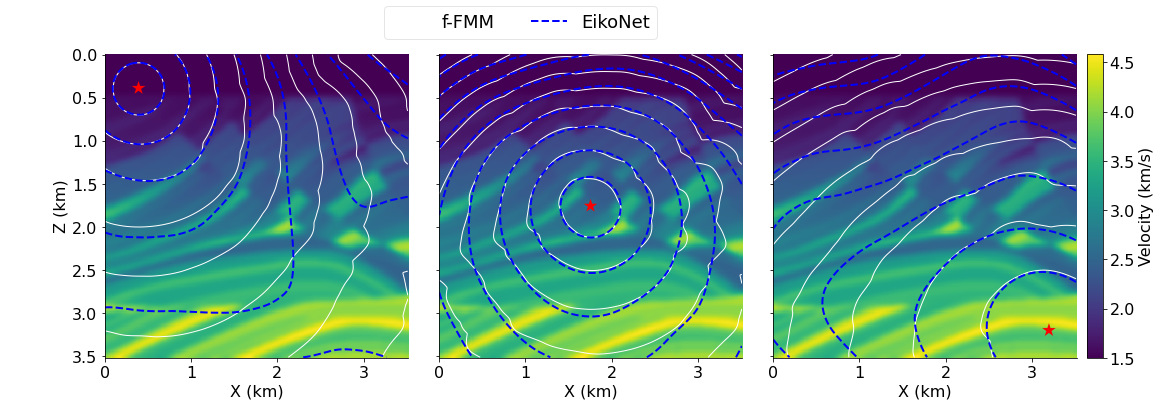

In [23]:
figs = []

labels = ['f-FMM', 'NES-TP', 'EikoNet']

colors = ['#000000', '#00FFFF', '#FF0000']
linestyles = ['solid', '-.', 'dashed']
linewidths = [5, 2.5, 2.5]

for t_ref, t_nes, t_eikonet in zip(T_ref, T_nes, T_eikonet):
  ixs = np.unravel_index(t_ref.argmin(), t_ref.shape)
  vmap = hv.Image((x, z, V_2d.T), vdims='Velocity (km/s)', 
                  kdims=['X (km)', 'Z (km)']).opts(cmap='viridis', colorbar=True)

  solutions = [t_ref, t_nes, t_eikonet]
  levels = np.linspace(0, np.nanmax(t_ref), 11)


  tmaps = [hv.Image((x, z, solutions[i].T), 
                    vdims='Time (s)', 
                    label=labels[i])
          for i in range(len(labels))]
  contours = [hv.operation.contours(tmaps[i], levels=levels).opts(color=colors[i],
                                                                  cmap=[colors[i]],
                                                          linestyle=linestyles[i], 
                                                          linewidth=linewidths[i]) 
              for i in range(len(tmaps))]

  source_point = hv.Scatter((x[ixs[0]], z[ixs[1]])).opts(marker='*', s=200, c='r')
  fig = hv.Overlay([vmap] + contours + [source_point])
  fig = fig.opts(hv.opts.Image(fig_size=150, aspect=xmax/zmax, invert_yaxis=True, 
                               fontsize=dict(ticks=16, labels=16, legend=16)))
  figs.append(fig.opts(show_legend=False))

figs[0] = figs[0].opts(hv.opts.Image(colorbar=False)).opts(yaxis='left')
figs[1] = figs[1].opts(hv.opts.Image(colorbar=False)).opts(show_legend=True,yaxis="bare",
                                                    legend_opts=dict(loc=(-0.18, 1.05), 
                                                    ncol=3, framealpha=0.5),
                fontsize=dict(ticks=16, labels=16,legend=18))
figs[2] = figs[2].opts(hv.opts.Image(yaxis="bare"), hv.opts.Scatter(yaxis="bare"))
fig = hv.Layout(figs).cols(3).opts(hspace=0.1, fig_size=125, aspect_weight=1, sublabel_format=' ')
fig